In [47]:
# 1. Imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# 2. Load Data & Define Features (NO VEGAS)
print("Loading Data...")
features_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')

TARGET = 'home_win'
drop_cols = [
    'game_id', 'season', 'week', 'home_team', 'away_team',
    'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit',
    'spread_line', 'total_line' # <--- PURE FOOTBALL ONLY
]
feature_cols = [col for col in features_df.columns if col not in drop_cols]

X = features_df[feature_cols].copy().fillna(0)
y = features_df[TARGET].copy()

Loading Data...


In [49]:
# 3. Split
TEST_SEASON = 2023
X_train = X[features_df['season'] < TEST_SEASON]
y_train = y[features_df['season'] < TEST_SEASON]
X_test = X[features_df['season'] == TEST_SEASON]
y_test = y[features_df['season'] == TEST_SEASON]

In [50]:
# 4. Scale (CRITICAL)
# The Neural Net and XGBoost models expect scaled data.
print("Scaling Data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling Data...


In [51]:
# 5. Load the 3 Nuclear Keys
print(f"{'-'*30}\nLoading the Triad...")
model_dir = config.MODELS_DIR / "advanced" / "NV"

try:
    with open(model_dir / "nv_xgboost_model.pkl", 'rb') as f:
        xgb_model = pickle.load(f)
    print("✅ Key 1: XGBoost Loaded")

    with open(model_dir / "nv_svm_model.pkl", 'rb') as f:
        svm_model = pickle.load(f)
    print("✅ Key 2: Random Forest Loaded")

    with open(model_dir / "nv_neural_net.pkl", 'rb') as f:
        nn_model = pickle.load(f)
    print("✅ Key 3: Neural Network Loaded")

except FileNotFoundError as e:
    print(f"❌ Error loading keys: {e}")
    print("Did you run all 05 notebooks?")

------------------------------
Loading the Triad...
✅ Key 1: XGBoost Loaded
✅ Key 2: Random Forest Loaded
✅ Key 3: Neural Network Loaded


In [54]:
# 6. Weight Optimizer (The "Brute Force" Search)
print(f"{'-'*30}\nSearching for the Perfect Weights...")

import itertools

# 6.1. Get the Raw Probabilities from each model
# We need the probability of "Home Win" (column 1)
prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
prob_nn = nn_model.predict_proba(X_test_scaled)[:, 1]

best_score = 0
best_weights = (0, 0, 0)

# 6.2. Define the Search Grid (Try weights from 0 to 5 for each model)
# e.g., (1, 0, 0) = Only XGB
# e.g., (1, 1, 1) = Average
# e.g., (3, 1, 5) = Heavy bias towards NN
weight_range = range(1, 20)

# 6.3. Iterate through every combination
for w_xgb, w_svm, w_nn in itertools.product(weight_range, repeat=3):

    if w_xgb + w_rf + w_nn == 0: continue # Skip all zeros

    # Calculate Weighted Average Probability
    weighted_prob = (
        (w_xgb * prob_xgb) +
        (w_svm * prob_svm) +
        (w_nn * prob_nn)
    ) / (w_xgb + w_svm + w_nn)

    # Convert to Class Prediction (Threshold 0.5)
    y_pred_combo = (weighted_prob > 0.5).astype(int)

    # Check Accuracy
    acc = accuracy_score(y_test, y_pred_combo)

    if acc > best_score:
        best_score = acc
        best_weights = (w_xgb, w_rf, w_nn)

print(f"\n✅ Optimization Complete.")
print(f"🏆 MAX POSSIBLE ACCURACY: {best_score * 100:.2f}%")
print(f"⚖️ Best Weights: XGB={best_weights[0]}, SVM={best_weights[1]}, NN={best_weights[2]}")

------------------------------
Searching for the Perfect Weights...

✅ Optimization Complete.
🏆 MAX POSSIBLE ACCURACY: 59.93%
⚖️ Best Weights: XGB=2, SVM=14, NN=8


------------------------------
Building Final Champion...
🚀 WE FOUND A NEW RECORD! (59.93%)
✅ Champion Model Saved.


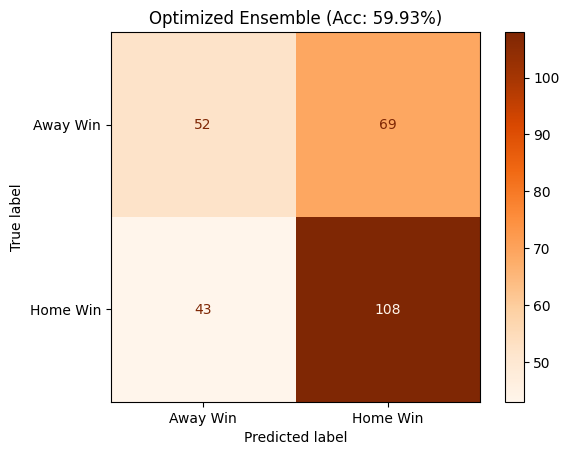

In [53]:
# 7. Final Verification & Save
# Now we apply those exact best weights to the final ensemble object
print(f"{'-'*30}\nBuilding Final Champion...")

if best_score > 0.592:
    print(f"🚀 WE FOUND A NEW RECORD! ({best_score * 100:.2f}%)")

    # Re-build ensemble with the winning weights
    champion_ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb_model),
            ('svm', svm_model),
            ('nn', nn_model)
        ],
        voting='soft',
        weights=list(best_weights),
        n_jobs=-1
    )

    # Fit on training data to finalize it
    champion_ensemble.fit(X_train_scaled, y_train)

    # Save
    OUTPUT_DIR = config.MODELS_DIR / "ensemble"
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    with open(OUTPUT_DIR / "nv_nuclear_ensemble.pkl", 'wb') as f:
        pickle.dump(champion_ensemble, f)
    print("✅ Champion Model Saved.")

    # Confusion Matrix of the Champion
    y_pred_final = champion_ensemble.predict(X_test_scaled)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, display_labels=['Away Win', 'Home Win'], cmap='Oranges')
    plt.title(f"Optimized Ensemble (Acc: {best_score*100:.2f}%)")
    plt.show()

else:
    print(f"⚠️ Even with optimization, we couldn't beat the individual models (Max: {best_score*100:.2f}%).")
    print("Recommendation: Use the Neural Network (05c) as the primary model.")